<a href="https://colab.research.google.com/github/andreea-cochintele/AI/blob/master/DeepLearning2Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metoda *1*


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot
# we need google drive access to upload the datasets
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Training settings    
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-12 20:16:25--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-12 20:16:25--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [      <=>           ]  33.20M  31.7MB/s    in 1.0s    

2021-04-12 20:16:26 (31.7 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

Labels of the shown images: tensor([6, 1, 4, 0, 7])


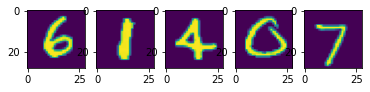

In [ ]:
# we create a loader to iterate through the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))
# set_trace()

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')


In [ ]:
# define two functions, one for training the model and one for testing it

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306483
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.371964
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.139642
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.158653
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.127451
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.172034
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.118978

Test set: Average loss: 0.0705, Accuracy: (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.082563
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.056550
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.046681
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.083189
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.028115
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.067568
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.006623

Test set: Average loss: 0.0424, Accuracy: (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.016775
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.118129
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.026115
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.048641
Train Epoch: 3 [

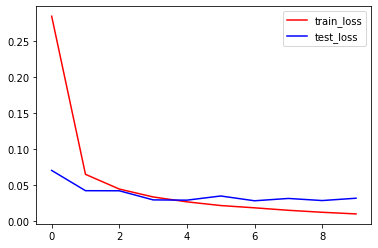

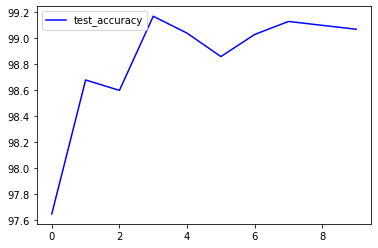

In [ ]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN().to(device)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 3):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist_cnn.pt")



np_dataset_large shape: (1000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)


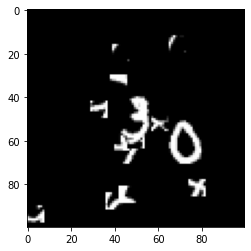

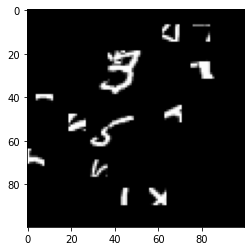

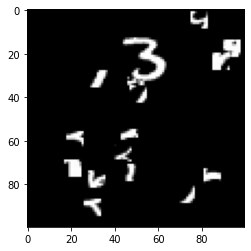

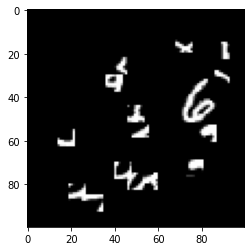

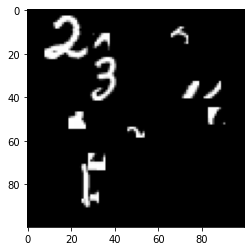

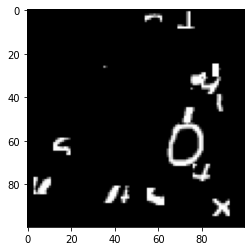

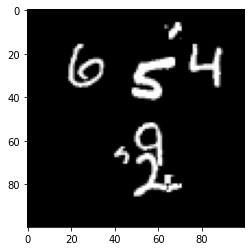

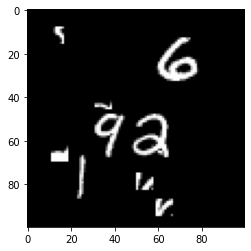

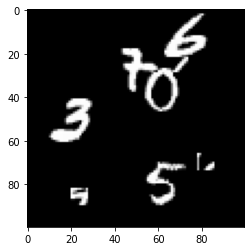

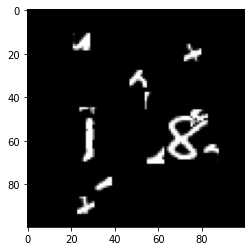

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt



def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
  # load the dataset as numpy arrays (tensors)
  with open(path,'rb') as handle:
    data = pickle.load(handle)
  
 
  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_no_count = data['no_count'].astype(np.float32)[:first_k]
  np_dataset_coords = data['coords'].astype(np.float32)[:first_k]
  
  # show a couple of examples from the dataset
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  for ii in range(5):
    example = np_dataset_large[10+ii].reshape((100, 100))
    plt.figure()
    plt.imshow(example, cmap="gray")
  
  # create loader from the numpy tensors
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_no_count = map(torch.tensor, 
                (np_dataset_large, np_dataset_no_count))
  #dataset_large = dataset_large.to(device)
  #dataset_coords = dataset_coords.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_no_count)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  
  return large_data_loader

# create both train and test dataset
path_train = '/content/gdrive/MyDrive/Colab/mnist_count_train.pickle'
path_test = '/content/gdrive/MyDrive/Colab/mnist_count_test.pickle'

large_data_loader_train = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=1000)
large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)



In [ ]:
# design the fully convolutional network   
# the first two conv layers should be the same as the original classification conv layers
# the last two conv layers should be transformed from the last two fully connected layers in the original network
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# data should be in [0,1]
def preprocess(data):
  return data.float() / 255.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# save the classification model
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

# define the fully_conv model
model_fuly_conv = CNN_fully_conv()

# load classification model
loaded_state_dict = torch.load(PATH)

# loaded_state_dict contain the weights of the classification model
# For the fully_conv model we will use exactly the same parameters.
# For the convolutional part we can directly load them as they have the same name.

# We need to convert the last fully-connected layers into convolutions
# For a single neuron we would just reshape the parameters from a vector into a kernel. 
# We just need to know what is the spatial dimension of the original fully-connected input.
# In our case, the first fully-connected had an input of size 4 x 4 x no_filter2, so we must use kernels of size 4 x 4 x no_filter2
# The second fully-connected receives as input just a vector(1x1 spatial dimension) of size no_neurons1 thus we use kernels of size 1 x 1 x no_neurons1
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
model_fuly_conv.load_state_dict(model_dict)
model_fuly_conv = model_fuly_conv.to(device)

print(model_fuly_conv.parameters)


Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


In [ ]:
# iterate over all the batches 
number = []
for batch_idx, (large_imgs, target_no) in enumerate(large_data_loader_test):
  large_imgs = preprocess(large_imgs)
  out_prob_maps = model_fuly_conv(large_imgs)
  # from the 10 maps, we select the index of the strongest activation and sort them in descending order
  sorted, indices = torch.sort(torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0],dim=1,descending = True)
  # we select the first 5  because we have maxim 5 number in an image
  max_ind = torch.index_select(sorted,dim=1,index=torch.tensor(range(5)))
  
  for i in range(args.batch_size):
    # iterate through batches
    # we know that we have at least 1 number and maxim 5 
    count = 0
    for j in range(5):
      # we select a threshold and if it's over it we assume that there is a number o we count it
      if max_ind[i,j] > -0.001: 
        count += 1
      # we verify if our predict is accurate and count it so we can compute accuracy later
      number.append(count==target_no[i])

# if number we have a vector of boolean numbers, 1 if our predict is accurate and 0 if not. We can copute the accuracy if we add up of of the number and divide by len of it
acc=sum(number)/len(number)
print(f'Accuracy {acc}')

Accuracy 0.20916666090488434


# Metoda 2

np_dataset_large shape: (1000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)


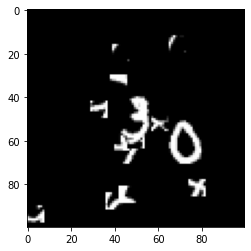

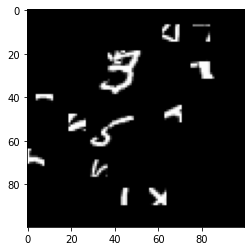

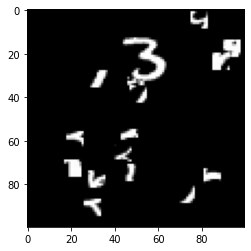

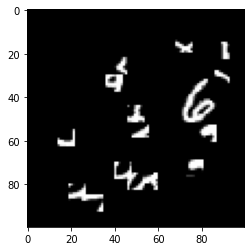

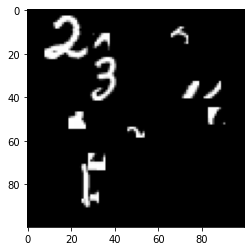

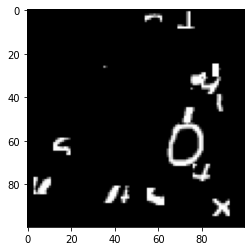

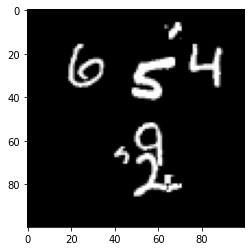

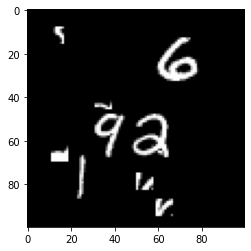

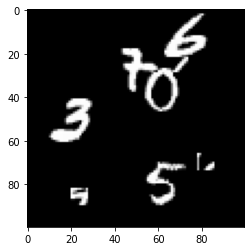

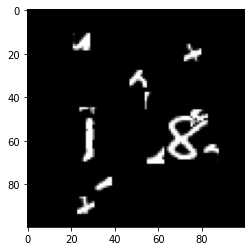

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt



def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
  # load the dataset as numpy arrays (tensors)
  with open(path,'rb') as handle:
    data = pickle.load(handle)
  

  # select only first_k elements in the dataset
  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_no_count = data['no_count'].astype(np.float32)[:first_k]
  np_dataset_coords = data['coords'].astype(np.float32)[:first_k]
  
  # show a couple of examples from the dataset
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  for ii in range(5):
    example = np_dataset_large[10+ii].reshape((100, 100))
    plt.figure()
    plt.imshow(example, cmap="gray")
  
  # create loader from the numpy tensors
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_no_count = map(torch.tensor, 
                (np_dataset_large, np_dataset_no_count))
  #dataset_large = dataset_large.to(device)
  #dataset_coords = dataset_coords.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_no_count)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  
  return large_data_loader

# create both train and test dataset
path_train = '/content/gdrive/MyDrive/Colab/mnist_count_train.pickle'
path_test = '/content/gdrive/MyDrive/Colab/mnist_count_test.pickle'

large_data_loader_train = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=1000)
large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)

In [ ]:
no_filters1 = 20
no_filters2 = 50
no_neurons1 = 500
class CNN1(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( 1, no_filters1, 5,  1)
        self.conv2 = nn.Conv2d( no_filters1, no_filters2, 5, 1)
        self.fc1 = nn.Conv2d( no_filters2, no_neurons1, 4)
        self.fc2 = nn.Conv2d( no_neurons1,  10, 1)
        self.linear = nn.Linear(19*19*10, 5)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        #x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).view(args.batch_size,-1)
        return self.linear(x)

In [ ]:
# define two functions, one for training the model and one for testing it

def train(args, model, device, train, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train):
        target=target.long() -1
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        data = preprocess(data)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.cross_entropy(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train),
                100. * batch_idx / len(train), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test:
            target=target.long() -1
            data, target = data.to(device), target.to(device)
            data = preprocess(data)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.cross_entropy(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

In [ ]:
# data should be in [0,1]
def preprocess(data):
  return data.float() / 255.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# save the classification model
PATH = 'conv_net1.pt'
torch.save(model.state_dict(), PATH)

# define the  model

model_pretrained = CNN1()

# load classification model
loaded_state_dict = torch.load(PATH)

model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
# load pretrained classification parameters into localisation model
model_pretrained.load_state_dict(model_dict, strict=False)
model_pretrained = model_pretrained.to(device)


Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias


Train Epoch: 1 [0/15 (0%)]	Loss: 1.610242

Test set: Average loss: 1.6332, Accuracy: (19%)

Train Epoch: 2 [0/15 (0%)]	Loss: 1.656366

Test set: Average loss: 1.7536, Accuracy: (19%)

Train Epoch: 3 [0/15 (0%)]	Loss: 1.768959

Test set: Average loss: 1.5647, Accuracy: (26%)

Train Epoch: 4 [0/15 (0%)]	Loss: 1.546152

Test set: Average loss: 1.4426, Accuracy: (44%)

Train Epoch: 5 [0/15 (0%)]	Loss: 1.460186

Test set: Average loss: 1.1536, Accuracy: (47%)

Train Epoch: 6 [0/15 (0%)]	Loss: 1.148916

Test set: Average loss: 1.0736, Accuracy: (49%)

Train Epoch: 7 [0/15 (0%)]	Loss: 1.033412

Test set: Average loss: 1.0757, Accuracy: (49%)

Train Epoch: 8 [0/15 (0%)]	Loss: 0.793783

Test set: Average loss: 0.9218, Accuracy: (57%)

Train Epoch: 9 [0/15 (0%)]	Loss: 0.591659

Test set: Average loss: 0.8035, Accuracy: (62%)

Train Epoch: 10 [0/15 (0%)]	Loss: 0.582253

Test set: Average loss: 0.9414, Accuracy: (57%)



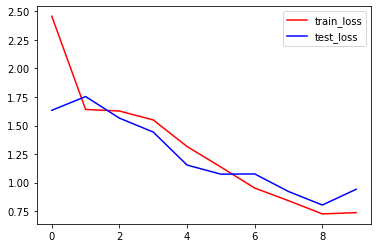

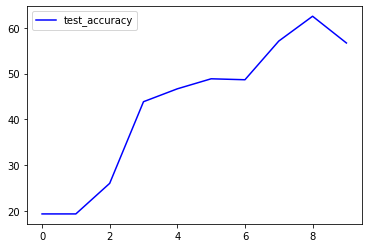

In [ ]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN1().to(device)
# create an Adam optimiser
optimizer = optim.Adam(model.parameters(), lr=args.lr)

losses_train = []
losses_test = []
accuracy_test = []


for epoch in range(1, args.epochs + 1):
    train_loss = train(args, model, device, large_data_loader_train,optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, large_data_loader_test)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist_count")
